# Dependencies

In [1]:
import pandas as pd
import numpy as np

In [2]:
import seaborn as sns

# Reading data

In [3]:
events_data = pd.read_csv('https://stepik.org/media/attachments/course/4852/event_data_train.zip')
events_data.head()

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632


In [4]:
submissions_data = pd.read_csv('https://stepik.org/media/attachments/course/4852/submissions_data_train.zip')
submissions_data.head()

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853


# EDA

## Creating target column

In [5]:
# users_data is dataframe for model training
users_data = events_data.groupby('user_id', as_index=False) \
    .agg({'timestamp': 'max'}).rename(columns={'timestamp': 'last_timestamp'})
users_data.head()

,user_id,last_timestamp
0,1,1472827464
1,2,1519226966
2,3,1444581588
3,5,1499859939
4,7,1521634660


In [6]:
# amount of correct and wrong submissions
all_time_users_scores = submissions_data.pivot_table(index='user_id',
                       columns='submission_status',
                       values='step_id',
                       aggfunc=lambda x: len(x.unique()),
                       fill_value=0).reset_index()
all_time_users_scores.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,12
2,5,2,1
3,8,9,7
4,14,0,1


In [7]:
# by requirements if student solved more than 40 practical tasks, he passes
users_data['passed_course'] = users_data.merge(all_time_users_scores, how='outer').correct > 40

In [8]:
users_data = users_data.drop(columns=['last_timestamp'])

In [9]:
users_data.head()

,user_id,passed_course
0,1,False
1,2,False
2,3,False
3,5,False
4,7,False


## Selecting desired timeframe of user's activity

In [10]:
# now that we know if the user have passed - we need to be able to predict it based on first 2 days on course
threshold = 2 * 24 * 60 * 60
cut_events_data = events_data[(events_data['timestamp'] < events_data.groupby('user_id')['timestamp'].transform('min') + threshold)]
users_events_data = cut_events_data.pivot_table(index='user_id',
                       columns='action',
                       values='step_id',
                       aggfunc='count',
                       fill_value=0).reset_index()
users_events_data.head()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,9
2,3,15,15,4,20
3,5,1,1,0,1
4,7,1,1,0,1


In [11]:
cut_submissions_data = submissions_data[(submissions_data['timestamp'] < 
                                        submissions_data.groupby('user_id')['timestamp'].transform('min') + threshold)]
users_scores = cut_submissions_data.pivot_table(index='user_id',
                       columns='submission_status',
                       values='step_id',
                       aggfunc=lambda x: len(x.unique()),
                       fill_value=0).reset_index()
users_scores.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,4,2
2,5,2,1
3,8,9,7
4,14,0,1


In [12]:
users_data = users_data.merge(users_scores, how='outer').fillna(0)

In [13]:
users_data = users_data.merge(users_events_data, how='outer')

## Creating features

In [14]:
cut_events_data = cut_events_data.assign(day=pd.to_datetime(cut_events_data['timestamp'], unit='s').dt.day)

In [15]:
# this feature shows, how many unique days have student spent on course
users_days = cut_events_data.groupby('user_id').day.nunique().to_frame().reset_index()
users_days = users_days.rename(columns={'day': 'days_on_course'}).fillna(0)

In [16]:
# this feature shows if student have solved last problem (then it is 0) and if not, how many attempts did he make
last_tried_step_by_user = cut_submissions_data.iloc[cut_submissions_data.reset_index().groupby('user_id').timestamp.idxmax()] \
                                            .loc[:,['step_id', 'user_id']]

last_tried_step_by_user = last_tried_step_by_user.merge(cut_submissions_data \
                                                             .drop(columns=['timestamp']), 
                                                        how='inner').rename(columns={'step_id': 'last_step_id'})
last_tried_step_by_user = last_tried_step_by_user.pivot_table(index='user_id',
                       columns='submission_status',
                       aggfunc=len,
                       fill_value=0).reset_index()
last_tried_step_by_user.columns = last_tried_step_by_user.columns.droplevel(0)
last_tried_step_by_user.rename(columns={'': 'user_id',
                                        'correct': 'last_step_completion',
                                        'wrong': 'last_step_wrong'}, inplace=True)
last_tried_step_by_user.last_step_wrong[last_tried_step_by_user.last_step_completion == 1] = 0 
last_tried_step_by_user = last_tried_step_by_user.drop(columns=['last_step_completion'])

In [17]:
# this feature shows if ratio of students correct solutions. Has higher correlation with target than separate correct or wrong.
# NaN means there was no submission activity from user
users_data = users_data.assign(correct_ratio=users_data.correct / (users_data.wrong + users_data.correct)) 

In [18]:
users_data = users_data.merge(users_days, how='outer')

In [19]:
# NaN means there was no submission activity from user
users_data = users_data.merge(last_tried_step_by_user, how='outer')

In [20]:
users_data.set_index('user_id', inplace=True)

In [21]:
users_data.head()

,passed_course,correct,wrong,discovered,passed,started_attempt,viewed,correct_ratio,days_on_course,last_step_wrong
user_id,,,,,,,,,,
1,False,0.0,0.0,1,0,0,1,NaN,1,NaN
2,False,2.0,0.0,9,9,2,9,1.000000,1,0.0
3,False,4.0,2.0,15,15,4,20,0.666667,1,0.0
5,False,2.0,1.0,1,1,0,1,0.666667,1,0.0
7,False,0.0,0.0,1,1,0,1,NaN,1,NaN


# Model selection

In [22]:
# if user hasnt even tried solving problems - best we can do is just assume that he isnt going to finish
na_free_users_data = users_data.dropna()
# if user has passed the test already - model doesn't need to study his behaviour
na_free_users_data = na_free_users_data[na_free_users_data.correct < 40]

In [23]:
close_to_completion = np.where(na_free_users_data.correct > 38)
no_problems = np.where(na_free_users_data.last_step_wrong == 0)
success_stories = na_free_users_data.passed_course.iloc[np.intersect1d(close_to_completion, no_problems)]
sum(success_stories) / success_stories.size

1.0

In [24]:
na_free_users_data.reset_index(inplace=True)
na_free_users_data.drop(index=np.intersect1d(close_to_completion, no_problems), inplace=True)

In [25]:
# na_free_users_data.set_index('user_id', inplace=True)

<Axes: >

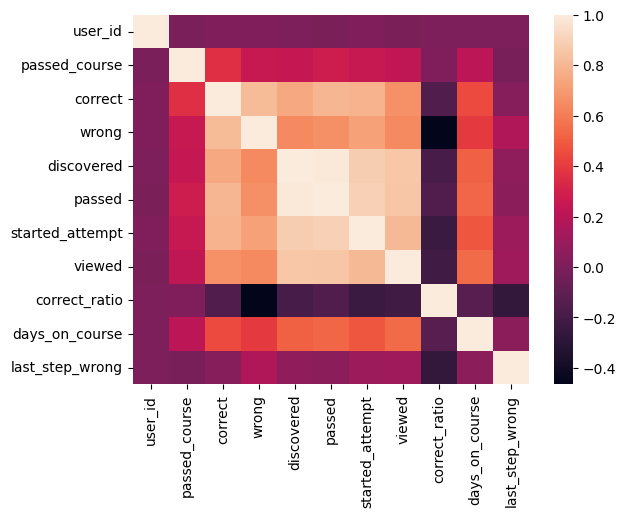

In [26]:
# interesting that user_id by itself doesnt correlate with course passing, yet, significantly improves model
corr = na_free_users_data.corr()
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [27]:
y = na_free_users_data.passed_course
X = na_free_users_data.drop(columns=['passed_course'])

In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [29]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV

calibrated_forest = CalibratedClassifierCV(estimator=RandomForestClassifier())
param_grid = {'estimator__max_depth': range(3, 21, 2),
            'estimator__min_samples_leaf': range(5, 21, 2)}
search = HalvingGridSearchCV(calibrated_forest, param_grid, 
                               resource='estimator__n_estimators', max_resources=50,
                               scoring='roc_auc')

In [30]:
search.fit(X_train, y_train)
# if you want to save time, best_params_ from one of the fits (train datasets are different every time, params might change):
# {'estimator__max_depth': 5, 'estimator__min_samples_leaf': 13, 'estimator__n_estimators': 27}

HalvingGridSearchCV(estimator=CalibratedClassifierCV(estimator=RandomForestClassifier()),
                    max_resources=50,
                    param_grid={'estimator__max_depth': range(3, 21, 2),
                                'estimator__min_samples_leaf': range(5, 21, 2)},
                    resource='estimator__n_estimators', scoring='roc_auc')

In [31]:
best_forest = search.best_estimator_

In [32]:
from sklearn.metrics import roc_auc_score
roc_auc_score(best_forest.predict(X_test), y_test)

0.6979552402112725

Keep in mind, that score is for a part of users that were detected as ambigious based on 2 days of data! Overall score of prediction would be much higher.

In [33]:
best_forest.fit(X, y)
# if you want to save time, still best_params_ = {'estimator__max_depth': 5, 'estimator__min_samples_leaf': 13, 'estimator__n_estimators': 27}

CalibratedClassifierCV(estimator=RandomForestClassifier(max_depth=7,
                                                        min_samples_leaf=17,
                                                        n_estimators=27))

# Prediction

## Creating dataframe with features for predictions

In [34]:
test_events_data = pd.read_csv('https://stepik.org/media/attachments/course/4852/events_data_test.csv')
test_events_data.head()

,step_id,timestamp,action,user_id
0,30456,1526893787,viewed,24417
1,30456,1526893797,viewed,24417
2,30456,1526893954,viewed,24417
3,30456,1526895780,viewed,24417
4,30456,1526893787,discovered,24417


In [35]:
test_submissions_data = pd.read_csv('https://stepik.org/media/attachments/course/4852/submission_data_test.csv')
test_submissions_data.head()

,step_id,timestamp,submission_status,user_id
0,31971,1526800961,wrong,24370
1,31971,1526800976,wrong,24370
2,31971,1526800993,wrong,24370
3,31971,1526801054,correct,24370
4,31972,1526800664,wrong,24370


In [36]:
test_users_data = pd.DataFrame({'user_id': test_events_data.user_id.unique()})

In [37]:
test_users_scores = test_submissions_data.pivot_table(index='user_id',
                       columns='submission_status',
                       values='step_id',
                       aggfunc=lambda x: len(x.unique()),
                       fill_value=0).reset_index()
test_users_scores.head()

submission_status,user_id,correct,wrong
0,12,1,0
1,13,29,10
2,15,10,5
3,21,24,16
4,35,7,5


In [38]:
test_users_data = test_users_data.merge(test_users_scores, how='outer').fillna(0)

In [39]:
test_users_events_data = test_events_data.pivot_table(index='user_id',
                       columns='action',
                       values='step_id',
                       aggfunc='count',
                       fill_value=0).reset_index()
test_users_events_data.head()

action,user_id,discovered,passed,started_attempt,viewed
0,4,1,1,0,1
1,6,1,1,0,1
2,10,2,2,0,6
3,12,11,9,4,14
4,13,70,70,35,105


In [40]:
test_users_data = test_users_data.merge(test_users_events_data, how='outer')

In [41]:
test_users_data = test_users_data.assign(correct_ratio=test_users_data.correct / (test_users_data.wrong + test_users_data.correct))

In [42]:
test_events_data = test_events_data.assign(day=pd.to_datetime(test_events_data['timestamp'], unit='s').dt.day)

In [43]:
test_users_days = test_events_data.groupby('user_id').day.nunique().to_frame().reset_index()
test_users_days.head()

,user_id,day
0,4,1
1,6,1
2,10,1
3,12,1
4,13,2


In [44]:
test_users_data = test_users_data.merge(test_users_days, how='outer')

In [45]:
test_last_tried_step_by_user = test_submissions_data.iloc[test_submissions_data.reset_index().groupby('user_id').timestamp.idxmax()] \
                                            .loc[:,['step_id', 'user_id']]

test_last_tried_step_by_user = test_last_tried_step_by_user.merge(test_submissions_data \
                                                             .drop(columns=['timestamp']), 
                                                        how='inner').rename(columns={'step_id': 'last_step_id'})
test_last_tried_step_by_user = test_last_tried_step_by_user.pivot_table(index='user_id',
                       columns='submission_status',
                       aggfunc=len,
                       fill_value=0).reset_index()
test_last_tried_step_by_user.columns = test_last_tried_step_by_user.columns.droplevel(0)
test_last_tried_step_by_user.rename(columns={'': 'user_id',
                                        'correct': 'last_step_completion',
                                        'wrong': 'last_step_wrong'}, inplace=True)
test_last_tried_step_by_user.last_step_wrong[test_last_tried_step_by_user.last_step_completion == 1] = 0 
test_last_tried_step_by_user = test_last_tried_step_by_user.drop(columns=['last_step_completion'])
test_last_tried_step_by_user.head()

submission_status,user_id,last_step_wrong
0,12,0
1,13,0
2,15,2
3,21,4
4,35,1


In [46]:
test_users_data = test_users_data.merge(test_last_tried_step_by_user, how='outer')

In [47]:
test_users_data = test_users_data.rename(columns={'day': 'days_on_course'})

## Predicting for inactive users

In [48]:
inds = np.where(test_users_data.correct_ratio.isna())[0]
y_pred = pd.DataFrame({'user_id': test_users_data.user_id[inds],
                       'is_gone': 0})
test_users_data = test_users_data.dropna()
y_pred

,user_id,is_gone
0,24417,0
1,999,0
2,26244,0
3,14192,0
4,12684,0
...,...,...
6179,7315,0
6180,24300,0
6181,820,0
6182,3649,0


## Predicting for active users

Very likely success

In [49]:
close_to_completion = np.where(test_users_data.correct > 38)
no_problems = np.where(test_users_data.last_step_wrong == 0)
success_stories = np.intersect1d(close_to_completion, no_problems)
y_success = pd.DataFrame({'user_id': test_users_data.iloc[success_stories].index,
                          'is_gone': 1})
y_pred = pd.concat([y_pred, y_success])

Success needs to be predicted by model

In [50]:
test_users_data.reset_index(inplace=True, drop=True)
test_X = test_users_data
test_X = test_users_data.drop(index=success_stories)
# test_X.set_index('user_id', inplace=True)
# test_X = test_X.drop(columns=['correct', 'wrong'])

In [51]:
active_y = pd.DataFrame({'user_id': test_X.index,
                        'is_gone': best_forest.predict_proba(test_X)[:,1]})
active_y

,user_id,is_gone
0,0,0.159693
1,1,0.097546
2,2,0.109107
3,3,0.100619
4,4,0.158729
...,...,...
2793,2798,0.064464
2794,2799,0.065699
2795,2800,0.082080
2796,2801,0.067396


In [52]:
y_pred = pd.concat([y_pred, active_y])

In [53]:
y_pred = y_pred.sort_values('user_id')

In [54]:
y_pred.set_index('user_id', inplace=True)

In [55]:
y_pred.to_csv('predictions.csv')

# Death step 
### Step on which the most students were lost
### (needed is we want to restructure the course, not just influence users that may drop out from current version)

In [56]:
last_tried_step_by_user = submissions_data.iloc[submissions_data.groupby('user_id').timestamp.idxmax()] \
                                            .loc[:,['step_id', 'user_id']]
# x is value of series with step_id = constant, containing column submission_status.
# returns truth is step in question failed the user, false otherwise
def mark_death_steps(x):
    # true if any wrong attempts were made
    wrong_attempts_existance = bool(sum(x == 'wrong'))
    correct_attempts_existance = bool(sum(x == 'correct'))
    # user tried, but never actually solved it
    if wrong_attempts_existance and not correct_attempts_existance:
        return True
    else:
        return False
# for every combination (user, his last step) add submission info
last_tried_step_by_user = last_tried_step_by_user.merge(submissions_data \
                                                             .drop(columns=['timestamp']), 
                                                         how='inner').rename(columns={'step_id': 'last_step_id'})
# since we already have only last tried step linked to every user, we can group by user to get their combination
death_mark = last_tried_step_by_user.groupby('user_id', as_index=False) \
                  .submission_status.agg(mark_death_steps).rename(columns = {'submission_status': 'death_step'})
# first delete redundant rows with submission info, then to each pair (user, his last step) add bool saying if this is the death step
death_steps_info = last_tried_step_by_user.drop(columns=['submission_status']).drop_duplicates() \
                     .merge(death_mark, on='user_id', how='inner')

In [57]:
coffin = pd.to_numeric(death_steps_info.groupby('last_step_id').death_step.sum()).idxmax()

In [58]:
coffin

31978